In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [5]:
from google.colab import drive
drive.mount('/content/drive/')
#drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [6]:
data = pd.read_csv("drive/MyDrive/clustering/data.csv")
data

,customer_unique_id,recency_days,frequency,total_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,1811.0,1.0,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1814.0,1.0,27.19
2,0000f46a3911fa3c0805444483337064,2236.0,1.0,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2020.0,1.0,43.62
4,0004aac84e0df4da2b147fca70cf8255,1987.0,1.0,196.89
...,...,...,...,...
91328,fffb09418989a0dbff854a28163e47c6,1954.0,1.0,73.16
91329,fffcf5a5ff07b0908bd4e2dbc735a684,2146.0,1.0,4134.84
91330,fffea47cd6d3cc0a88bd621562a9d061,1961.0,1.0,84.58
91331,ffff371b4d645b6ecea244b27531430a,2267.0,1.0,112.46


In [7]:
data = data.drop(["customer_unique_id"], axis=1)

## Standard scaler

In [8]:
# Let's scale the data first
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[-0.82023697, -0.16458591, -0.112062  ],
       [-0.80058099, -0.16458591, -0.29171575],
       [ 1.96435913, -0.16458591, -0.19926556],
       ...,
       [ 0.16256165, -0.16458591, -0.20183406],
       [ 2.16747084, -0.16458591, -0.15816963],
       [-0.76782104, -0.16458591, -0.12492014]])

# Kmeans

In [11]:
kmeans = KMeans(3, n_init='auto')
kmeans.fit(data_scaled)
#kmeans.save('drive/MyDrive/clustering/kmeans.h5')

KMeans(n_clusters=3, n_init='auto')

## Save kmeans model

In [12]:
import pickle

filename = 'drive/MyDrive/clustering/kmeans.h5'

# save model
pickle.dump(kmeans, open(filename, "wb"))

# Load kmeans model

In [13]:
# load model
kmeans = pickle.load(open(filename, "rb"))

In [13]:
print("K-Means Silhouette score: ", silhouette_score(data_scaled, kmeans.labels_))

K-Means Silhouette score:  0.528848873669398


# Construction and training of the "Autoencoder"

In [14]:
import tensorflow as tf
from keras import layers, losses
from keras.optimizers import *
from keras.layers import Input, Add, Dense
from keras.models import Model, load_model

In [15]:
encoding_dim = 3 #nb_clusters

input_df = Input(shape=(3,)) #nb_features

# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution
x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(64, activation='relu', kernel_initializer='normal')(x)
x = Dense(32, activation='relu', kernel_initializer='normal')(x)
encoded = Dense(10, activation='relu', kernel_initializer='normal')(x)
x = Dense(32, activation='relu', kernel_initializer='normal')(encoded)
x = Dense(64, activation='relu', kernel_initializer='normal')(x)
decoded = Dense(3, activation = 'sigmoid', kernel_initializer='normal')(x) #nb_features

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)
autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [16]:
data_scaled.shape

(91333, 3)

In [17]:
autoencoder.fit(data_scaled, data_scaled, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25
714/714 [==============================] - 5s 4ms/step - loss: 0.8217
Epoch 2/25
714/714 [==============================] - 2s 3ms/step - loss: 0.7426
Epoch 3/25
714/714 [==============================] - 3s 4ms/step - loss: 0.7398
Epoch 4/25
714/714 [==============================] - 2s 2ms/step - loss: 0.7390
Epoch 5/25
714/714 [==============================] - 2s 2ms/step - loss: 0.7386
Epoch 6/25
714/714 [==============================] - 2s 2ms/step - loss: 0.7386
Epoch 7/25
714/714 [==============================] - 2s 2ms/step - loss: 0.7385
Epoch 8/25
714/714 [==============================] - 2s 2ms/step - loss: 0.7382
Epoch 9/25
714/714 [==============================] - 2s 2ms/step - loss: 0.7382
Epoch 10/25
714/714 [==============================] - 3s 5ms/step - loss: 0.7382
Epoch 11/25
714/714 [==============================] - 4s 6ms/step - loss: 0.7382
Epoch 12/25
714/714 [==============================] - 3s 4ms/step - loss: 0.7382
Epoch 13/25
714/714 [====

In [18]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 12        
                                                                 
 dense_8 (Dense)             (None, 64)                256       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                                 
 dense_11 (Dense)            (None, 32)                352       
                                                                 
 dense_12 (Dense)            (None, 64)                2112

In [19]:
autoencoder.save_weights('drive/MyDrive/clustering/autoencoder.h5')

In [20]:
pred = encoder.predict(data_scaled)

2855/2855 [==============================] - 9s 3ms/step


In [21]:
pred.shape

(91333, 10)

# Training new model

In [22]:
ae_kmeans = kmeans.fit(pred)

In [24]:
filename2 = 'drive/MyDrive/clustering/ae_kmeans.h5'

# save model
pickle.dump(ae_kmeans, open(filename2, "wb"))

In [25]:
print("new K-Means Silhouette score : ", silhouette_score(pred, ae_kmeans.labels_))

K-Means Silhouette score:  0.6641607


# PCA

In [34]:
# Obtain the principal components
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-2.736198,1.042326
1,-2.859187,0.926340
2,12.095286,-0.276981
3,0.519048,-0.846685
4,-1.246582,-1.233302


In [36]:
labels = ae_kmeans.labels_
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-2.736198,1.042326,2
1,-2.859187,0.926340,2
2,12.095286,-0.276981,1
3,0.519048,-0.846685,0
4,-1.246582,-1.233302,2


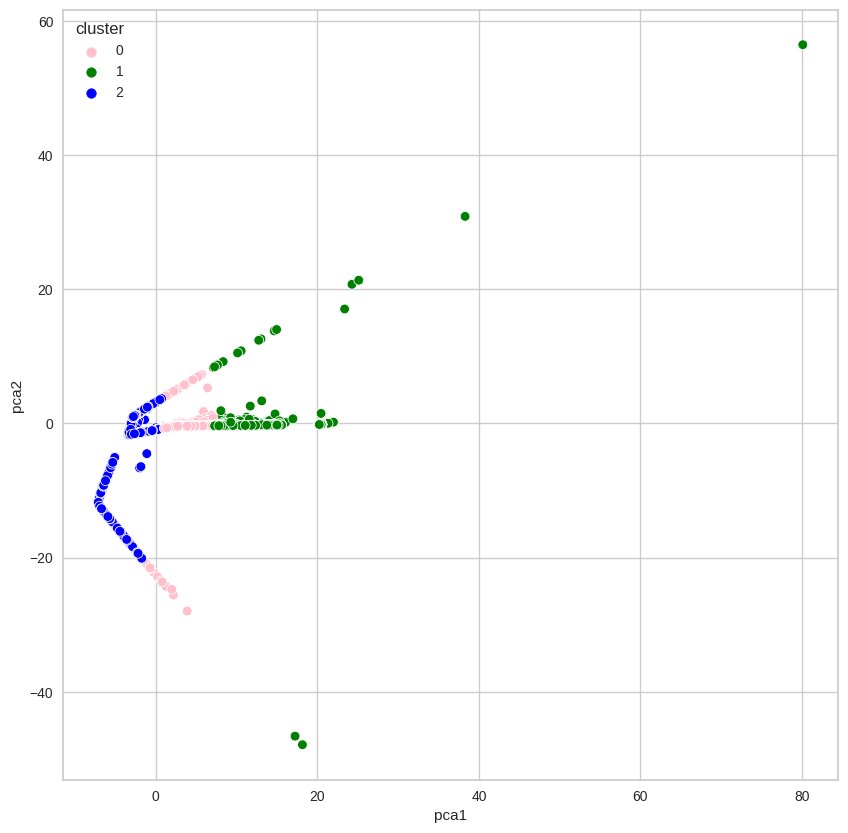

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['pink','green','blue'])
plt.show()